# TP1 : Extreme value theory

# Rain data in south England
**Question 1 Make the same Exploratory Data Analysis as in the previous questions to check if the data has seasonality, and can be modeled by a Gaussian**

In [8]:
import warnings
warnings.filterwarnings('ignore')

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
import statsmodels.tsa.stattools as ts
import seaborn as sns
from scipy import stats
from pyextremes import plot_mean_residual_life, plot_parameter_stability
from scipy.stats import genextreme


df_rain = pd.read_csv("rain.csv")

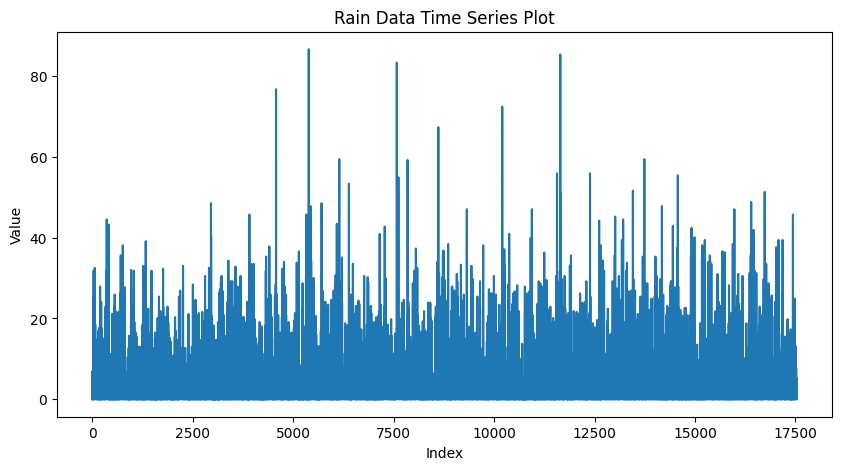

ADF Statistic: -30.580304384101527
p-value: 0.0
Critical Values: {'1%': -3.4307233450435692, '5%': -2.8617050041000534, '10%': -2.5668578273974973}
The series is stationary (reject the null hypothesis).


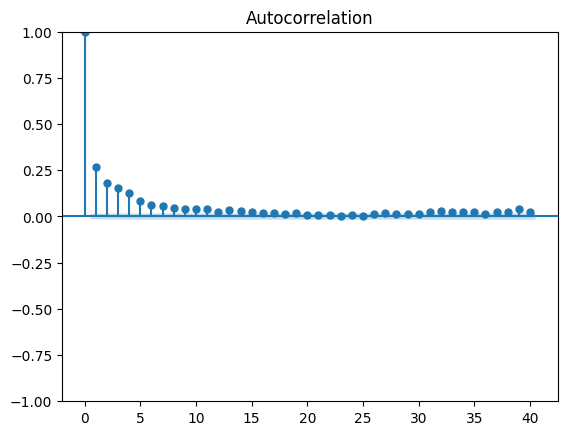

In [5]:
# Time series plot
plt.figure(figsize=(10, 5))
plt.plot(df_rain)
plt.title('Rain Data Time Series Plot')
plt.xlabel('Index')
plt.ylabel('Value')
plt.show()

# ADF test
adf_test = ts.adfuller(df_rain)
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
print("Critical Values:", adf_test[4])
# Low p-value means unit-root hypothesis rejected, series is stationary
if adf_test[1] < 0.05:
    print("The series is stationary (reject the null hypothesis).")
else:
    print("The series is not stationary (fail to reject the null hypothesis).")

# ACF Plot
sm.graphics.tsa.plot_acf(df_rain, lags=40)
plt.show()

The data did not seem to have any seasonalities or trends and appears stationnary. An ADFuller test was done to confirm the stationnarity of the dataset.

Nonetheless, the time series is autocorrelated up to 5 lags back, this is problematic as the core hypotheses of MDA is not respected as the $(X_i)_{1\leq i\leq n}$ are not iid. By fitting an AR(5) model we remove the autocorrlation of the time series.

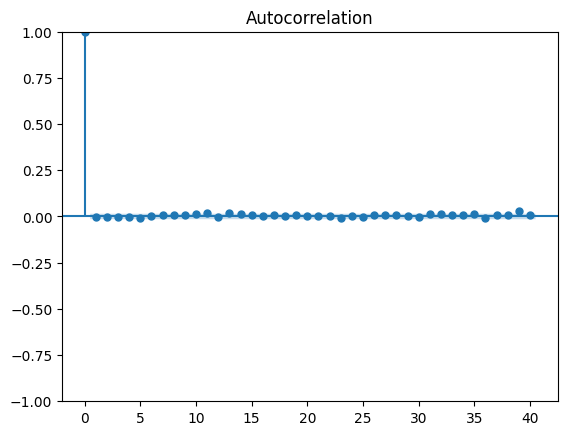

In [6]:
from statsmodels.tsa.arima.model import ARIMA

model = ARIMA(df_rain, order=(5, 0, 0))
model_fit = model.fit()
sm.graphics.tsa.plot_acf(model_fit.resid, lags=40)
plt.show()

Ljung-Box Test Results:
      lb_stat  lb_pvalue
25  28.63221   0.279582


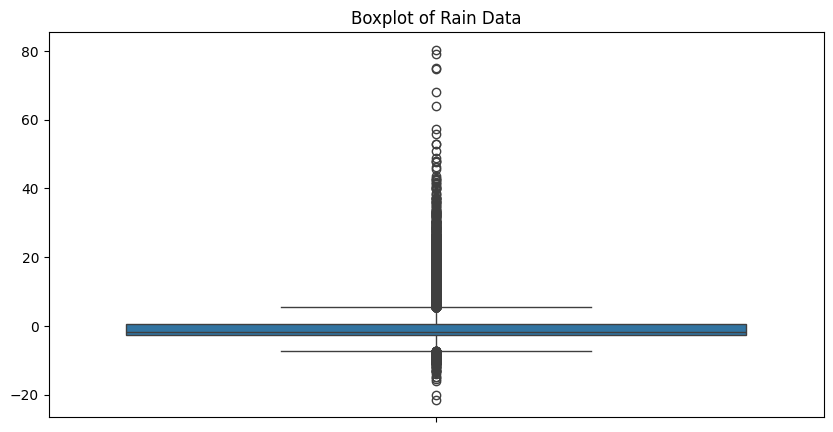

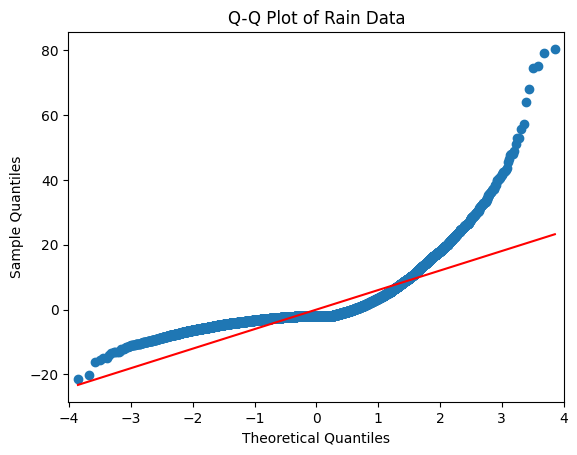

Shapiro-Wilk Test Statistic: 0.6869329993590575
p-value: 1.503641610437728e-100
The data is not normally distributed (reject the null hypothesis).


In [36]:
# 6. Ljung-Box test for stationarity
ljung_box_test = sm.stats.acorr_ljungbox(model_fit.resid, lags=[25], return_df=True)
print("Ljung-Box Test Results:\n", ljung_box_test)

# 7. Check if the data is Gaussian

# Boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(model_fit.resid)
plt.title("Boxplot of Rain Data")
plt.show()

# Q-Q Plot
sm.qqplot(model_fit.resid.sort_values(), line="s")
plt.title("Q-Q Plot of Rain Data")
plt.show()

# Shapiro-Wilk test for normality
shapiro_test = stats.shapiro(model_fit.resid)
print("Shapiro-Wilk Test Statistic:", shapiro_test[0])
print("p-value:", shapiro_test[1])

# Interpretation of Shapiro-Wilk test
if shapiro_test[1] < 0.05:
    print("The data is not normally distributed (reject the null hypothesis).")
else:
    print("The data is normally distributed (fail to reject the null hypothesis).")

The QQ plot really shows us, especially on the tails of the distribution, the theoretical quantiles are below the empirical ones. Without fitting a power law to efficiently estimate the tail of the model. We can still compute the skewness and the kurtosis and value how unlikely the distribution is to be a normal distribution:

In [15]:
model_fit.resid.skew(), model_fit.resid.kurt()

(3.272516212123908, 18.32556473942665)

**Question 2 a Propose a method to estimate the 100 year return level based on *peaks over threshold*.**

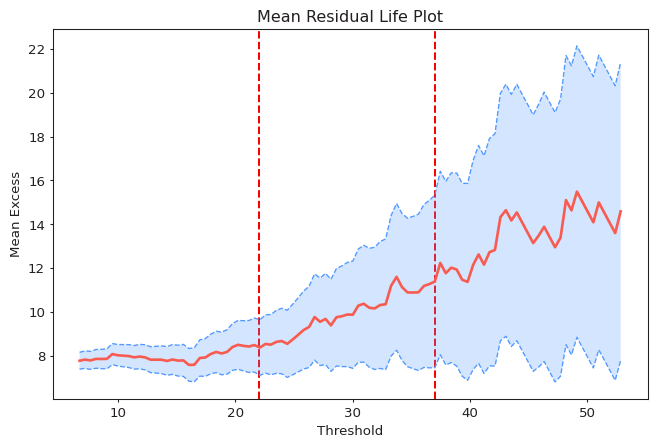

In [16]:
plot_mean_residual_life(model_fit.resid)
plt.title("Mean Residual Life Plot")
plt.xlabel("Threshold")
plt.ylabel("Mean Excess")
plt.axvline(22, linestyle="--", color="red")
plt.axvline(37, linestyle="--", color="red")
plt.show()

The linear MRL interval is around the interval $[22, 37]$. The threshold we need to choose in the POT method is in this interval.

We also note that the linearity around the previous interval is more visible using the residuals of the AR(5) model than the base time series.  

In [31]:
u = 30
data = model_fit.resid.to_numpy()
data_thresh = data[data > u] - u
xi_fit, mu_fit, sigma_fit = stats.genpareto.fit(data_thresh)


proba_above_thresh = len(data_thresh) / len(data)

# We compute the estimated quantile
alpha_100 = 1 / (100 * 365)
u_100 = u + sigma_fit / xi_fit * ((alpha_100 / proba_above_thresh) ** (-xi_fit) - 1)
print(f"GDP 100 years return level: {u_100}")

GDP 100 years return level: 101.71335118688513


**Question 2 b Propose a method to estimate the 100 year return level based on *block maxima***

In [34]:
# Take full years in rain dataset
data = model_fit.resid.iloc[: len(df_rain) // 365 * 365]

# Reshape the data as blocks of 365 days of data
data = data.to_numpy().reshape((365, len(data) // 365))

In [28]:
# We fit a GEV distribution onto the block maxima
block_maxima = data.max(axis=0)
c_fit, mu_fit, scale_fit = genextreme.fit(block_maxima)

xi_fit = -c_fit

We want to test the GEV hypothesis, and see how well the fit actually is. 

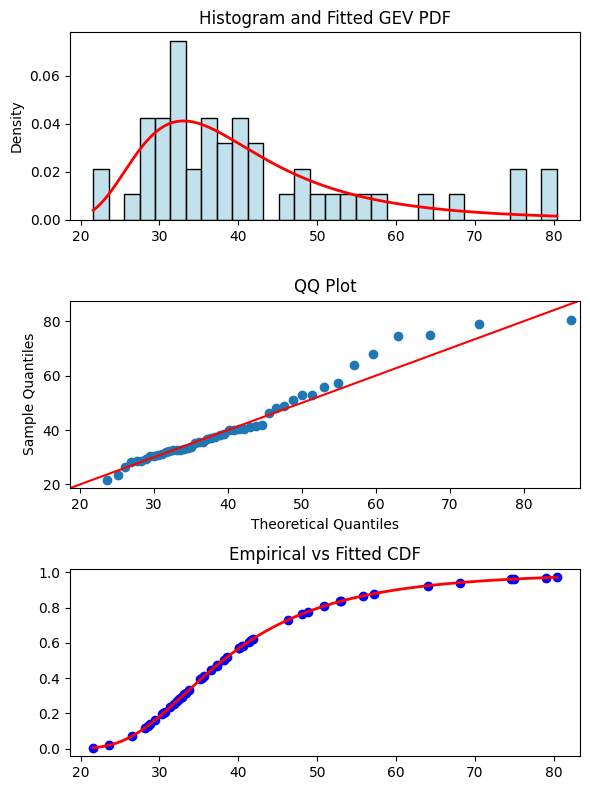

In [29]:
fig, axes = plt.subplots(3, figsize=(6, 8))

# Histogram and GEV PDF
ax1 = axes[0]
sns.histplot(
    block_maxima, bins=30, kde=False, stat="density", ax=ax1, color="lightblue"
)
x = np.linspace(min(block_maxima), max(block_maxima), 1000)
gev_pdf = genextreme.pdf(x, c_fit, loc=mu_fit, scale=scale_fit)
ax1.plot(x, gev_pdf, "r-", lw=2, label="GEV PDF")
ax1.set_title("Histogram and Fitted GEV PDF")

# QQ Plot
ax2 = axes[1]
sm.qqplot(
    np.sort(block_maxima),
    dist=genextreme(c_fit, loc=mu_fit, scale=scale_fit),
    line="45",
    ax=ax2,
)
ax2.set_title("QQ Plot")

# Probability plot (CDF)
ax3 = axes[2]
gev_cdf = genextreme.cdf(np.sort(block_maxima), c_fit, loc=mu_fit, scale=scale_fit)
ax3.plot(np.sort(block_maxima), gev_cdf, "bo", label="Empirical")
ax3.plot(
    x,
    genextreme.cdf(x, c_fit, loc=mu_fit, scale=scale_fit),
    "r-",
    lw=2,
    label="GEV CDF",
)
ax3.set_title("Empirical vs Fitted CDF")

plt.tight_layout()
plt.show()

- On the histogram plot, one can notice that the number of block maxima $M=\frac{n}{365} \simeq 48$. So having more data to obtain a greater value of $M$ woudl yield better distributed results.

- Globally, the empirical and theoretical quantiles match for the major part, yet the more extreme quantiles are unprecise. This is likely due to the extreme values in density that modify the behaviour of the empirical density.

- Furthermore, the empirical and fitted cdf seem to really fit, so the choice of the fitted parameters is adequate.

We now compute the quantiles of the GEV distribution, with $T$ in years:
$$1 - \frac{1}{T} = \exp\left(-\left(1+\frac{u_{100}-\mu}{\sigma}\right)^{\frac{-1}{\xi}}\right) \iff u_{100} = \frac{\sigma}{\xi}\left(\log\left(\frac{T}{T - 1}\right)^{-\xi}-1\right) + \mu$$

In [30]:
u_100_gev = sigma_fit / xi_fit * (np.log(100/99) ** (-xi_fit) - 1) + mu_fit
print(f"GEV 100 years return level: {u_100_gev}")

GEV 100 years return level: 104.03991459407828


**Question 3 - Compare the estimations obtained in both models.**

The two models give us similar quantiles value.

We note that $\hat z_{100, GDP} \in [95, 105]$ for the different values of the threshold we choose. This is due to the valid set of values for the threshold using the MRL method being between 22 and 37.

The results yielded in the residuals setting are more stable than the one of the plain dataset, where the interval is $[95, 120]$.